# Imports

In [104]:
from pathlib import Path
from datetime import datetime
from typing import Callable, Optional, Sequence, Tuple
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import uncertainty_toolbox as uct
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import LightningModule

# Uploads

In [105]:
prefix = "./data/earth"
prefix_1A = "./data/flight/titer"
uploaded = {p.name: p for p in Path(prefix).glob("*.xlsx") if not p.name.startswith("~$")}
uploaded_1A = {p.name: p for p in Path(prefix_1A).glob("*.xlsx") if not p.name.startswith("~$")}

# Settings

In [106]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [107]:
plt.rcParams.update({
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
})
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 120

# Preprocessing

In [108]:
organism_list = []
substance_list = []
gravity_list = []
obj_list = []

class Preprocess:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_list, self.organism)
    self.update_list(substance_list, self.substance)
    self.update_list(gravity_list, self.gravity)

  def update_list(self, item_list, item):
    item_list.append(item)

In [109]:
for file_name in uploaded.keys():
  obj = Preprocess(file_name)
  obj_list.append(obj)

In [110]:
organism_encode = LabelEncoder()
substance_encode = LabelEncoder()
gravity_encode = LabelEncoder()

organism_label = organism_encode.fit_transform(organism_list)
substance_label = substance_encode.fit_transform(substance_list)
gravity_label = gravity_encode.fit_transform(gravity_list)

In [111]:
data_list = []

class Data:
  def __init__(self,file_name, organism, substance, gravity, flight = False):
    self.file_name = file_name
    self.organism = organism
    self.substance = substance
    self.gravity = gravity
    self.flight = flight

    self.titer_time, self.titer_val = self.assign_data()
    self.titer_input_np = []
    self.titer_val_np = []

    if len(self.titer_time) != 0:
      self.titer_input_np = self.create_inputs(self.titer_time, self.titer_val)
    if len(self.titer_val) != 0:
      self.titer_val_np = self.titer_val.reshape(-1, 1)

  def assign_data(self):
    titer_time = []
    titer_val = []

    if substance_encode.inverse_transform([self.substance])[0] != "Wild":
      if self.flight:
        titer_df = pd.read_excel(f"{prefix_1A}/{self.file_name}", sheet_name = 1).iloc[1:]
      else:
        titer_df = pd.read_excel(f"{prefix}/{self.file_name}", sheet_name = 1).iloc[1:]
      titer_time = titer_df.iloc[:,:1].to_numpy()
      titer_df_transpose = titer_df.iloc[:,1:].T
      titer_df_transpose.fillna(titer_df_transpose.mean(), inplace=True)
      titer_val = titer_df_transpose.T.to_numpy()

    return titer_time, titer_val

  def create_inputs(self, input, output):
    """
    Returns inputs in order of organism, substance, gravity, and time
    """
    input_length = len(input)
    output_length = len(output[0])

    input_stacked = np.tile(input, output_length).reshape(-1, 1)

    categorical_inputs = [self.organism, self.substance, self.gravity]
    categorical_inputs_stacked = np.tile(categorical_inputs, input_length * output_length).reshape(-1, len(categorical_inputs))
    return np.hstack((categorical_inputs_stacked, input_stacked)).astype(float)

In [ ]:
for i, obj in enumerate(obj_list):
  data_obj = Data(obj.file_name, organism_label[i], substance_label[i], gravity_label[i])
  data_list.append(data_obj)

In [113]:
titer_input = data_list[0].titer_input_np
titer_output = data_list[0].titer_val_np

for i in range(1, len(data_list)):
  if len(data_list[i].titer_input_np) > 0:
    titer_input = np.vstack((titer_input, data_list[i].titer_input_np))
    titer_output = np.vstack((titer_output, data_list[i].titer_val_np))

In [114]:
titer_time_input_mean = np.mean(titer_input[:, 3])
titer_time_input_std_dev = np.std(titer_input[:, 3])
titer_input[:,3] = (titer_input[:, 3] - titer_time_input_mean)/titer_time_input_std_dev
titer_output = np.log(titer_output + 0.1)

In [115]:
titer_input_train, titer_input_test_val, titer_output_train, titer_output_test_val = train_test_split(titer_input, titer_output, test_size = 0.2, random_state = 42)
titer_input_val, titer_input_test, titer_output_val, titer_output_test = train_test_split(titer_input_test_val, titer_output_test_val, test_size = 0.5, random_state = 42)

In [116]:
titer_input_train_tensor = torch.tensor(titer_input_train, device=device)
titer_input_test_tensor = torch.tensor(titer_input_test,device=device)
titer_output_train_tensor = torch.tensor(titer_output_train,device=device)
titer_output_test_tensor = torch.tensor(titer_output_test,device=device)
titer_input_val_tensor = torch.tensor(titer_input_val, device=device)
titer_output_val_tensor = torch.tensor(titer_output_val, device=device)

# Model

In [117]:
class MLP(torch.nn.Module):
    """MLP Network."""

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_sizes: Sequence[int],
        hidden_activation: Callable[[torch.tensor], torch.tensor] = F.relu,
        out_activation: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        """Constructor.

        Args:
            input_dim: Dimension of input data.
            output_dim: Dimesnion of data outputted.
            hidden_sizes: List of sizes for the hidden layers.
            hidden_activation: Hidden activation function.
            out_activation: The activation function to apply on output.
        """
        super().__init__()
        if len(hidden_sizes) == 0:
            self._add_linear_layer(input_dim, output_dim, 0)
            self.n_layers = 1
        else:
            self._add_linear_layer(input_dim, hidden_sizes[0], 0)
            for hidx in range(len(hidden_sizes) - 1):
                self._add_linear_layer(
                    hidden_sizes[hidx], hidden_sizes[hidx + 1], hidx + 1
                )
            self._add_linear_layer(hidden_sizes[-1], output_dim, len(hidden_sizes))
            self.n_layers = len(hidden_sizes) + 1
        self.hidden_activation = hidden_activation
        self.out_activation = out_activation

    def forward(
        self,
        net_in: torch.tensor,
    ) -> torch.tensor:
        """Forward pass through network.

        Args:
            net_in: The input to the network.

        Returns:
            The output of the network.
        """
        curr = net_in
        for layer_num in range(self.n_layers - 1):
            curr = getattr(self, "linear_%d" % layer_num)(curr)
            curr = self.hidden_activation(curr)
        curr = getattr(self, "linear_%d" % (self.n_layers - 1))(curr)
        if self.out_activation is not None:
            return self.out_activation(curr)
        return curr

    def _add_linear_layer(
        self,
        lin_in: int,
        lin_out: int,
        layer_num: int,
    ) -> None:
        """Add a linear layer to the network.

        Args:
            lin_in: Input dimension to the layer.
            lin_out: Output dimension of the layer.
            layer_num: The number of the layer being added.
        """
        layer = torch.nn.Linear(lin_in, lin_out)
        self.add_module("linear_%d" % layer_num, layer)

In [118]:
class PNN(LightningModule):
    """Probabilistic neural network (PNN) outputting Gaussian distribution.

    This model is implemented as a two headed neural network. The two heads
    output the mean and logvariance of a multi-variate normal.
    """

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        encoder_hidden_sizes: Sequence[int],
        encoder_output_dim: int,
        mean_hidden_sizes: Sequence[int],
        logvar_hidden_sizes: Sequence[int],
        hidden_activation: Callable[[torch.tensor], torch.tensor] = F.relu,
        learning_rate: float = 1e-3,
    ):
        """Constructor.

        Args:
            input_dim: Dimension of input data.
            output_dim: Dimesnion of data outputted.
            hidden_activation: Hidden activation function.
            encoder_hidden_sizes: List of the hidden sizes for the encoder.
            encoder_output_dim: Dimension of the data outputted by the encoder.
            mean_hidden_sizes: List of hidden sizes for mean head.
            logvar_hidden_sizes: List of hidden sizes for logvar head.
        """
        super().__init__()
        self._learning_rate = learning_rate
        self.encoder = MLP(
            input_dim=input_dim,
            output_dim=encoder_output_dim,
            hidden_sizes=encoder_hidden_sizes,
            hidden_activation=hidden_activation,
        )
        self.mean_head = MLP(
            input_dim=encoder_output_dim,
            output_dim=output_dim,
            hidden_sizes=mean_hidden_sizes,
            hidden_activation=hidden_activation,
        )
        self.logvar_head = MLP(
            input_dim=encoder_output_dim,
            output_dim=output_dim,
            hidden_sizes=logvar_hidden_sizes,
            hidden_activation=hidden_activation,
        )

    def get_mean_and_standard_deviation(
        self,
        x_data: np.ndarray,
        device: str = "cpu",
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Get the mean and standard deviation prediction.

        Args:
            x_data: The data in numpy ndarray form.
            device: The device to use. Should be the same as the device
                the model is currently on.

        Returns:
            Mean and standard deviation as ndarrays
        """
        with torch.no_grad():
            mean, logvar = self.forward(torch.tensor(x_data, device=device))
        mean = mean.numpy()
        std = (logvar / 2).exp().numpy()
        return mean, std

    def forward(
        self,
        x_data: torch.tensor,
    ) -> Tuple[torch.tensor, torch.tensor]:
        """Get the mean and standard deviation prediction.

        Args:
            x_data: The data in tensor form.

        Returns:
            Mean and log variance as tensors.
        """
        latent = self.encoder(x_data)
        return self.mean_head(latent), self.logvar_head(latent)

    def training_step(
        self,
        batch: Tuple[torch.tensor, torch.tensor],
        batch_idx: int,
    ) -> torch.tensor:
        """Do a training step.

        Args:
            batch: The x and y data to train on.
            batch_idx: Index of he batch.

        Returns:
            The loss.
        """
        x_data, y_data = batch
        mean, logvar = self.forward(x_data)
        loss = torch.mean(self.compute_nll(mean, logvar, y_data))
        self.log("train_loss", loss)
        return loss

    def validation_step(
        self,
        batch: Tuple[torch.tensor, torch.tensor],
        batch_idx: int,
    ) -> None:
        """Do a validation step.

        Args:
            batch: The x and y data to train on.
            batch_idx: Index of he batch.
        """
        x_data, y_data = batch
        mean, logvar = self.forward(x_data)
        loss = torch.mean(self.compute_nll(mean, logvar, y_data))
        self.log("validation_loss", loss)

    def test_step(
        self,
        batch: Tuple[torch.tensor, torch.tensor],
        batch_idx: int,
    ) -> None:
        """Do a validation step.

        Args:
            batch: The x and y data to train on.
            batch_idx: Index of he batch.
        """
        x_data, y_data = batch
        mean, logvar = self.forward(x_data)
        loss = torch.mean(self.compute_nll(mean, logvar, y_data))
        self.log("test_loss", loss)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Configure the optimizer.

        Returns:
            Optimizer
        """
        return torch.optim.Adam(self.parameters(), lr=self._learning_rate)

    def compute_nll(
        self,
        mean: torch.tensor,
        logvar: torch.tensor,
        labels: torch.tensor,
    ) -> torch.tensor:
        """Compute the loss as negative log likelihood.

        Args:
            mean: The mean prediction for labels.
            logvar: The logvariance prediction for labels.
            labels: The observed labels of the data.

        Returns:
            The negative log likelihood of each point.
        """
        sqdiffs = (mean - labels) ** 2
        return torch.exp(-logvar) * sqdiffs + logvar

In [119]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=4,
    output_dim=1,
    encoder_hidden_sizes=[50, 50, 50, 50, 50],
    encoder_output_dim=50,
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
    hidden_activation = F.relu,
    learning_rate = 1e-3,
)

In [120]:
model_path = './models/titer'
time_path = ".pth"
pnn.load_state_dict(torch.load(model_path + time_path))

<All keys matched successfully>

In [121]:
for name, param in pnn.named_parameters():
  if 'encoder' in name:
    param.requires_grad = False

# Flight

In [122]:
organism_1A_list = []
substance_1A_list = []
gravity_1A_list = []
obj_1A_list = []

In [123]:
class Preprocess_flight:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity, self.flight = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_1A_list, self.organism)
    self.update_list(substance_1A_list, self.substance)
    self.update_list(gravity_1A_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [124]:
for file_name in uploaded_1A.keys():
  obj = Preprocess_flight(file_name)
  obj_1A_list.append(obj)

In [125]:
def locate_label(var, var_list, var_encode_list):
  index = var_list.index(var)
  return var_encode_list[index]

In [126]:
data_1A_list = []
input_standardized_all_list = []
input_standardized_all_tensor = None
output_all_tensor = None

for i, obj in enumerate(obj_1A_list):


    organism_locate_label = locate_label(obj.organism, organism_list, organism_label)
    substance_locate_label = locate_label(obj.substance, substance_list, substance_label)
    gravity_locate_label = locate_label(obj.gravity, gravity_list, gravity_label)

    #use the combination of labels to locate the correct obj_list item
    data_obj = Data(obj.file_name, organism_locate_label, substance_locate_label, gravity_locate_label, flight = True)
    if substance_encode.inverse_transform([data_obj.substance])[0] != "Wild":
      data_1A_list.append(data_obj)

      #combine into categorical inputs
      categorical_inputs = [organism_locate_label, substance_locate_label, gravity_locate_label]
      categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()

      time_tensor = torch.tensor(data_obj.titer_input_np[:,3], dtype = torch.float32)
      categorical_inputs_transformed_stacked = torch.Tensor.repeat(categorical_inputs_transformed, len(time_tensor)).reshape(-1, len(categorical_inputs))

      input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_tensor.reshape(-1, 1)))
      input_unstandardized[:,3] = (input_unstandardized[:,3] - titer_time_input_mean) / titer_time_input_std_dev

      input_standardized = input_unstandardized
      input_standardized_all_list.append(input_standardized)
      if input_standardized_all_tensor is None:
        input_standardized_all_tensor = torch.tensor(input_standardized)
        output_all_tensor = torch.tensor(data_obj.titer_val_np)
      else:
        input_standardized_all_tensor = torch.vstack((input_standardized_all_tensor, input_standardized))
        output_all_tensor = torch.vstack((output_all_tensor, torch.tensor(data_obj.titer_val_np)))
output_all_tensor = torch.log(output_all_tensor + 0.1)

C:\Users\ipjos\AppData\Local\Temp\ipykernel_18280\2907603904.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titer_df_transpose.fillna(titer_df_transpose.mean(), inplace=True)
C:\Users\ipjos\AppData\Local\Temp\ipykernel_18280\1583529748.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_standardized_all_tensor = torch.tensor(input_standardized)


In [127]:
model_path_2 = './models/titer_transfer_learning'
if not model_path_2:
  #80% train, 10% validation, 10% test
  input_train, input_test_val, output_train, output_test_val = train_test_split(input_standardized_all_tensor, output_all_tensor , test_size = 0.2, random_state = 42)
  input_val, input_test, output_val, output_test = train_test_split(input_test_val, output_test_val, test_size = 0.5, random_state = 42)

  train_data = DataLoader(TensorDataset(torch.tensor(input_train, dtype = torch.float32), torch.tensor(output_train, dtype = torch.float32)))
  test_data = DataLoader(TensorDataset(torch.tensor(input_test, dtype = torch.float32), torch.tensor(output_test, dtype = torch.float32)))
  val_data = DataLoader(TensorDataset(torch.tensor(input_val, dtype = torch.float32), torch.tensor(output_val, dtype = torch.float32)))


  """Train the model with a pytorch-lightning trainer."""
  trainer = pl.Trainer(max_epochs=100, check_val_every_n_epoch=50)
  trainer.fit(pnn, train_data, val_data)
  test_results = trainer.test(pnn, test_data)
  timestamp = datetime.now()
  time_path = f"_{timestamp.strftime('%m-%d_%H-%M-%S')}.pth"
  torch.save(pnn.state_dict(), model_path_2 + time_path)
else:
  #load the model
  time_path = ".pth"
  pnn.load_state_dict(torch.load(model_path_2 + time_path))

C:\Users\ipjos\AppData\Local\Temp\ipykernel_18280\787291360.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, logvar = self.forward(torch.tensor(x_data, device=device))


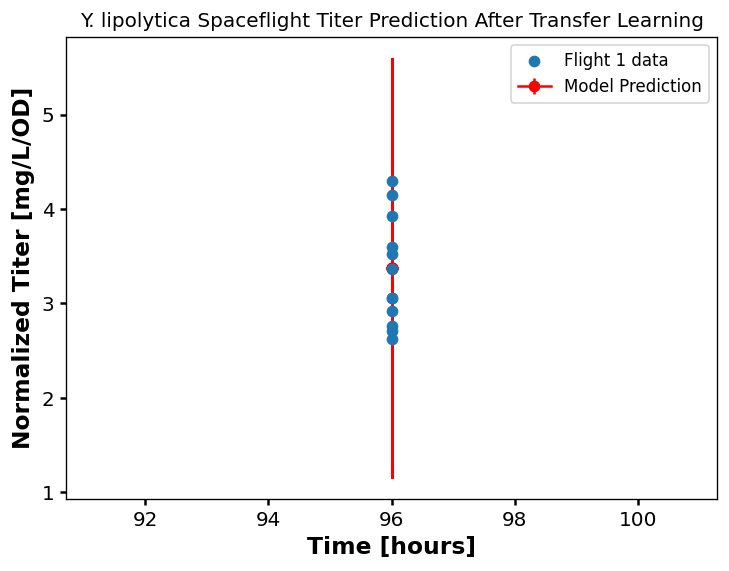

In [129]:
for i, obj in enumerate(data_1A_list):

  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized_all_list[i])

  time_tensor = input_standardized_all_list[i][:, 3] * titer_time_input_std_dev + titer_time_input_mean

  predicted_output_mean = predicted_output_mean.flatten()
  predicted_output_std = predicted_output_std.flatten()

  # plt.title(f"{organism_encode.inverse_transform([data_1A_list[i].organism])[0]} {substance_encode.inverse_transform([data_1A_list[i].substance])[0]} {gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Titer with 95% Confidence Interval")
  plt.title("Y. lipolytica Spaceflight Titer Prediction After Transfer Learning")
  plt.errorbar(time_tensor,
               np.exp(predicted_output_mean) - 0.1,
               np.exp(predicted_output_mean + 3 * predicted_output_std) - np.exp(predicted_output_mean),
               marker = 'o',
               color = 'red',
               # label = f"{gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Prediction",
               label = "Model Prediction",
               zorder = 1)

  plt.scatter(time_tensor,
              data_1A_list[i].titer_val_np,
              label = "Flight 1 data",
              zorder = 2)

  plt.xlabel("Time [hours]")
  plt.ylabel("Normalized Titer [mg/L/OD]")
  plt.legend()
  plt.show()
